In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import random

os.chdir('Resources/')

import warnings
warnings.filterwarnings("ignore")

In [2]:
def elgamal_keygen(p=7919, g=2):
    x = random.randint(1, p - 2)  # private key
    h = pow(g, x, p)              # public key
    return (p, g, h), x

def elgamal_encrypt(m, pub_key):
    p, g, h = pub_key
    y = random.randint(1, p - 2)
    c1 = pow(g, y, p)
    s = pow(h, y, p)
    c2 = (m * s) % p
    return (c1, c2)

def elgamal_decrypt(ciphertext, priv_key, p):
    c1, c2 = ciphertext
    s = pow(c1, priv_key, p)
    s_inv = pow(s, -1, p)
    return (c2 * s_inv) % p

def elgamal_add(*ciphertexts, p):
    c1_product = 1
    c2_product = 1
    for c1, c2 in ciphertexts:
        c1_product = (c1_product * c1) % p
        c2_product = (c2_product * c2) % p
    return (c1_product, c2_product)


In [3]:
def preprocess_dataset(path, seed=42):
    df = pd.read_csv(path)
    X = df[['Store', 'Dept', 'IsHoliday', 'Year', 'Month', 'Day']].values
    y = df['Weekly_Sales'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    rf_model = RandomForestRegressor(n_estimators=71, random_state=seed)
    rf_model.fit(X_train, y_train)
    X_train_aug = np.hstack((X_train, rf_model.predict(X_train).reshape(-1, 1)))
    X_test_aug = np.hstack((X_test, rf_model.predict(X_test).reshape(-1, 1)))
    return X_train_aug, X_test_aug, y_train, y_test

def build_mlp(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(100, activation='relu', input_shape=(input_dim,)),
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def train_local(X_train, X_test, y_train, y_test):
    model = build_mlp(X_train.shape[1])
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
    y_pred = model.predict(X_test)
    return model, r2_score(y_test, y_pred)

def get_gradients(model, X_train, y_train):
    mse_loss_fn = tf.keras.losses.MeanSquaredError()
    X_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
    y_tensor = tf.convert_to_tensor(y_train.reshape(-1, 1), dtype=tf.float32)
    with tf.GradientTape() as tape:
        predictions = model(X_tensor, training=True)
        loss = mse_loss_fn(y_tensor, predictions)
    return tape.gradient(loss, model.trainable_variables)

def add_noise_to_gradients(grads, noise_stddev=1.0):
    return [g + tf.random.normal(shape=g.shape, stddev=noise_stddev) for g in grads]

def add_masking_to_gradients(grads, mask_value=5):
    return [g + mask_value for g in grads]

def flatten_and_encrypt(grads, pub_key):
    encrypted = []
    for g in grads:
        flat = tf.reshape(g, [-1]).numpy()
        encrypted.extend([elgamal_encrypt(int(round(val)), pub_key) for val in flat])
    return encrypted

def reconstruct_grads(flat_grads, model):
    reconstructed = []
    idx = 0
    for var in model.trainable_variables:
        shape = var.shape
        size = np.prod(shape)
        chunk = flat_grads[idx:idx + size]
        tensor = tf.convert_to_tensor(np.array(chunk, dtype=np.float32).reshape(shape))
        reconstructed.append(tensor)
        idx += size
    return reconstructed

def apply_gradients(model, avg_grads):
    optimizer = tf.keras.optimizers.Adam()
    optimizer.apply_gradients(zip(avg_grads, model.trainable_variables))

def fine_tune(model, X_train, y_train):
    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

In [4]:
clients = [f"1_{i}_Client_Data_" for i in range(1, 16)]
rounds = [
    "2010_2", "2010_3", "2010_4", "2010_5", "2010_6", "2010_7", "2010_8", "2010_9", "2010_10", "2010_11", "2010_12",
    "2011_1", "2011_2", "2011_3", "2011_4", "2011_5", "2011_6", "2011_7", "2011_8", "2011_9", "2011_10", "2011_11", "2011_12",
    "2012_1", "2012_2", "2012_3", "2012_4", "2012_5", "2012_6", "2012_7", "2012_8", "2012_9", "2012_10"
    ]

client_models = {}

client_r2_history = {i: [] for i in range(15)}

print("Round 2010_2")
train_data = {}
for idx, client in enumerate(clients):
    path = client + rounds[0] + ".csv"
    X_train, X_test, y_train, y_test = preprocess_dataset(path, seed=42)
    model, r2 = train_local(X_train, X_test, y_train, y_test)
    client_r2_history[idx].append(r2)
    print(f"R² of Client_{idx+1} ({rounds[0]}): {r2:.4f}")
    train_data[idx] = (X_train, X_test, y_train, y_test)
    client_models[idx] = model

r_0102 = random.randint(1, 500)
r_0203 = random.randint(1, 500)
r_0304 = random.randint(1, 500)
r_0405 = random.randint(1, 500)
r_0506 = random.randint(1, 500)
r_0607 = random.randint(1, 500)
r_0708 = random.randint(1, 500)
r_0809 = random.randint(1, 500)
r_0910 = random.randint(1, 500)
r_1011 = random.randint(1, 500)
r_1112 = random.randint(1, 500)
r_1213 = random.randint(1, 500)
r_1314 = random.randint(1, 500)
r_1415 = random.randint(1, 500)
r_1501 = random.randint(1, 500)

mask = [0] * 15
mask[0]  = -r_1501 + r_0102
mask[1]  = -r_0102 + r_0203
mask[2]  = -r_0203 + r_0304
mask[3]  = -r_0304 + r_0405
mask[4]  = -r_0405 + r_0506
mask[5]  = -r_0506 + r_0607
mask[6]  = -r_0607 + r_0708
mask[7]  = -r_0708 + r_0809
mask[8]  = -r_0809 + r_0910
mask[9]  = -r_0910 + r_1011
mask[10] = -r_1011 + r_1112
mask[11] = -r_1112 + r_1213
mask[12] = -r_1213 + r_1314
mask[13] = -r_1314 + r_1415
mask[14] = -r_1415 + r_1501

pub_key, priv_key = elgamal_keygen()

enc_grads_list = []

for i, (idx, model) in enumerate(client_models.items()):
    X_train, _, y_train, _ = train_data[idx]
    
    grad = get_gradients(model, X_train, y_train)
    noisy_grad = add_noise_to_gradients(grad, noise_stddev=1.0)
    masked_grad = add_masking_to_gradients(noisy_grad, mask[i])
    
    enc_grads = flatten_and_encrypt(masked_grad, pub_key)
    enc_grads_list.append(enc_grads)


avg_enc_grads = [
    elgamal_add(*grads, p=pub_key[0])
    for grads in zip(*enc_grads_list)
]
avg_decrypted = [elgamal_decrypt(g, priv_key, pub_key[0]) // len(clients) for g in avg_enc_grads]

for round_id in rounds[1:]:
    print(f"\nRound ({round_id})")
    new_train_data = {}
    new_client_models = {}

    for idx, client in enumerate(clients):
        path = client + round_id + ".csv"
        X_train, X_test, y_train, y_test = preprocess_dataset(path, seed=42)

        model = build_mlp(X_train.shape[1])
        model(X_train[:1])
        avg_grads_tensor = reconstruct_grads(avg_decrypted, model)
        apply_gradients(model, avg_grads_tensor)

        fine_tune(model, X_train, y_train)
        r2 = r2_score(y_test, model.predict(X_test))
        client_r2_history[idx].append(r2)
        print(f"R² of Client_{idx+1} ({round_id}): {r2:.4f}")

        new_train_data[idx] = (X_train, X_test, y_train, y_test)
        new_client_models[idx] = model
    
    r_0102 = random.randint(1, 500)
    r_0203 = random.randint(1, 500)
    r_0304 = random.randint(1, 500)
    r_0405 = random.randint(1, 500)
    r_0506 = random.randint(1, 500)
    r_0607 = random.randint(1, 500)
    r_0708 = random.randint(1, 500)
    r_0809 = random.randint(1, 500)
    r_0910 = random.randint(1, 500)
    r_1011 = random.randint(1, 500)
    r_1112 = random.randint(1, 500)
    r_1213 = random.randint(1, 500)
    r_1314 = random.randint(1, 500)
    r_1415 = random.randint(1, 500)
    r_1501 = random.randint(1, 500)

    mask = [0] * 15
    mask[0]  = -r_1501 + r_0102
    mask[1]  = -r_0102 + r_0203
    mask[2]  = -r_0203 + r_0304
    mask[3]  = -r_0304 + r_0405
    mask[4]  = -r_0405 + r_0506
    mask[5]  = -r_0506 + r_0607
    mask[6]  = -r_0607 + r_0708
    mask[7]  = -r_0708 + r_0809
    mask[8]  = -r_0809 + r_0910
    mask[9]  = -r_0910 + r_1011
    mask[10] = -r_1011 + r_1112
    mask[11] = -r_1112 + r_1213
    mask[12] = -r_1213 + r_1314
    mask[13] = -r_1314 + r_1415
    mask[14] = -r_1415 + r_1501

    pub_key, priv_key = elgamal_keygen()
    enc_grads_list = []
    for idx, model in new_client_models.items():
        X_train, _, y_train, _ = new_train_data[idx]

        grad = get_gradients(model, X_train, y_train)
        noisy_grad = add_noise_to_gradients(grad, noise_stddev=1.0)
        masked_grad = add_masking_to_gradients(noisy_grad, mask[i])
        
        enc_grads = flatten_and_encrypt(masked_grad, pub_key)
        enc_grads_list.append(enc_grads)

    avg_enc_grads = [
        elgamal_add(*grads, p=pub_key[0])
        for grads in zip(*enc_grads_list)
    ]
    avg_decrypted = [elgamal_decrypt(g, priv_key, pub_key[0]) // len(clients) for g in avg_enc_grads]

    client_models = new_client_models
    train_data = new_train_data

Round 2010_2
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
R² of Client_1 (2010_2): 0.9558
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
R² of Client_2 (2010_2): 0.8730
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
R² of Client_3 (2010_2): 0.9135
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
R² of Client_4 (2010_2): 0.9405
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
R² of Client_5 (2010_2): 0.8701
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
R² of Client_6 (2010_2): 0.9377
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
R² of Client_7 (2010_2): 0.9458
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
R² of Client_8 (2010_2): 0.9515
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
R² of Client_9 (2010_2): 0.8977
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
R² of Client_10 (2010_2): 0.8106
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
R² of Client_11 (2010_2): 0.9714
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
R² of Client_12 (2010_2): 0.9029
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
R² of Client_13 (2010_2): 0.9265
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
R² of Client_14 (2010_2): 0.9760
5/

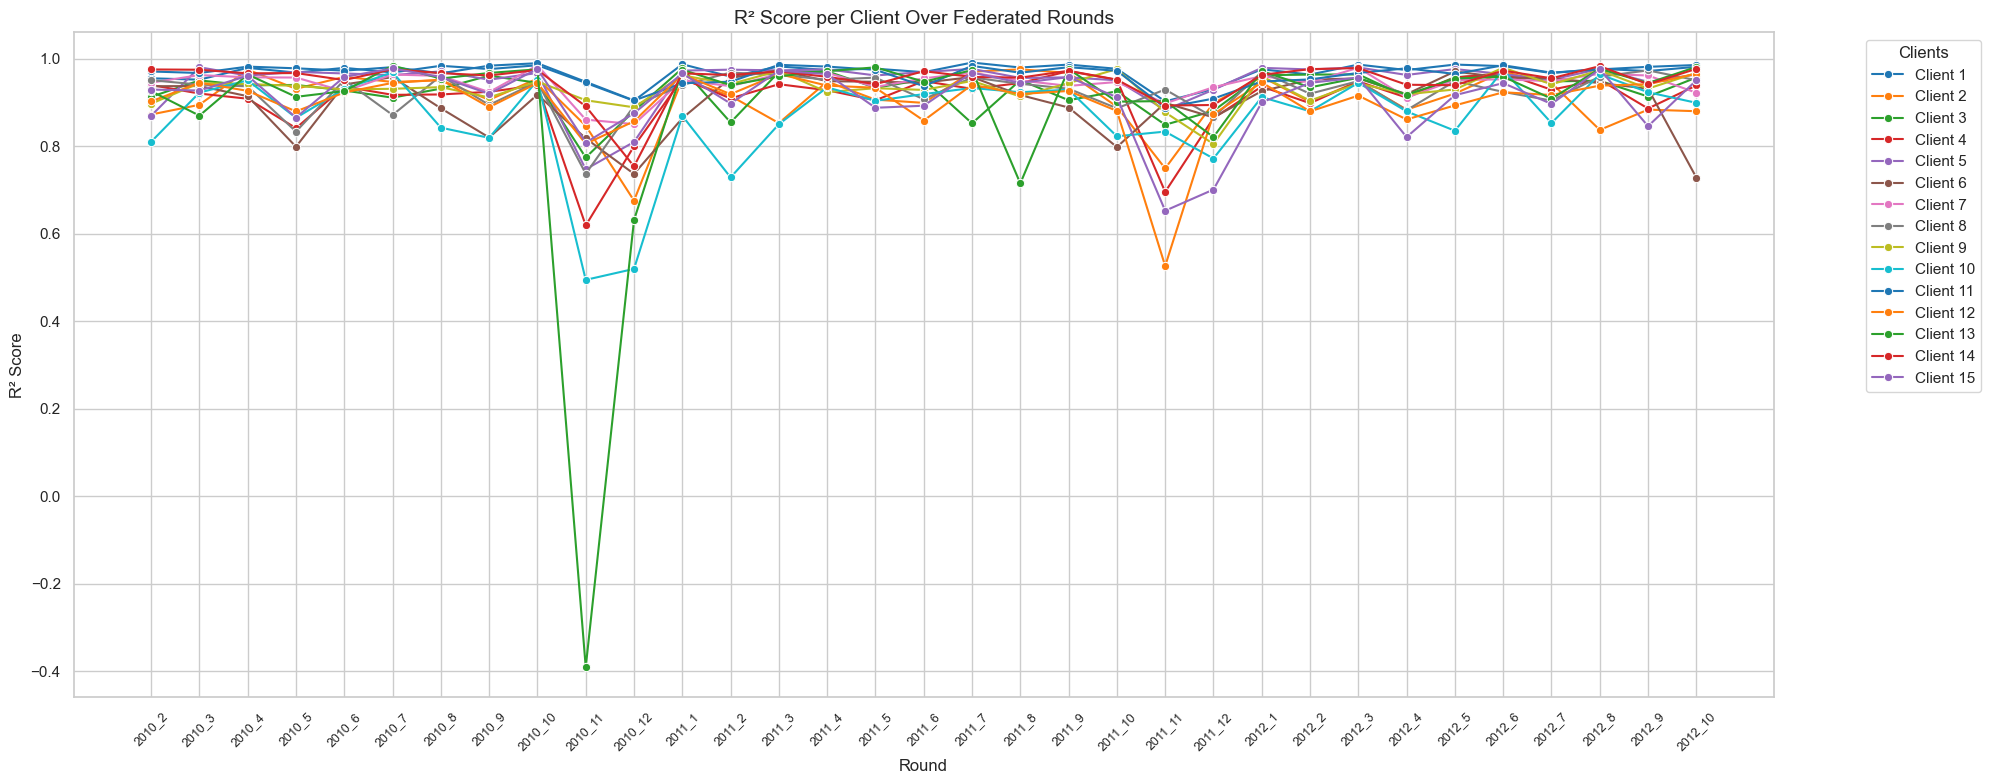

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

data = []
for client_id, r2_list in client_r2_history.items():
    for round_idx, r2 in enumerate(r2_list):
        data.append({
            "Client": f"Client {client_id + 1}",
            "Round": rounds[round_idx],
            "R² Score": r2
        })

df_r2 = pd.DataFrame(data)
df_r2.to_csv("2_15_Client_r2_History.csv", index=False)

plt.figure(figsize=(20, 8))
sns.set(style="whitegrid")

sns.lineplot(data=df_r2, x="Round", y="R² Score", hue="Client", marker="o", palette="tab10")

plt.title("R² Score per Client Over Federated Rounds", fontsize=14)
plt.xlabel("Round", fontsize=12)
plt.ylabel("R² Score", fontsize=12)
plt.xticks(rotation=45, fontsize=9)
plt.legend(title="Clients", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()